# Homework 1 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ dataset as we see in two exercises. 

Try to use as much as HiveQL as possible and use pandas operations only when it's necessary.

__Hand-in:__
- __Due: 24.03.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your queries readable


__Cluster Usage__

As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.

__Documentation__

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>


In [3]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline

from pyhive import hive
username = os.environ['JUPYTERHUB_USER']
# create connection
conn = hive.connect(host='iccluster059.iccluster.epfl.ch', port=10000, username=username) 
# create cursor
cur = conn.cursor()

## Data from SBB/CFF/FFS

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

### Get yourself ready

If you have gone through the exercises by yourself, you are free to go for the questions. If you haven't gone through the exercises, you can follow the next two cells to get all your databases and tables ready.

__In Shell__:

```bash
hdfs dfs -mkdir   -p                              /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    user:hive:r-x             /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m group::r-x                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m other::---                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:group::r-x        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:other::---        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -m    user:hive:rwx             /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    default:user:hive:rwx     /user/${JUPYTERHUB_USER}/hive
```

__In Python__:
```python
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)
```

In [4]:
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)

### Question I.a - 5 Points

In the exercise, you were asked to find how many stops of each type of transportation for the date 05.11.2018. Now, let's do the same for the whole dataset. 

Show the results with a stacked bar chart (you can use `pandas` to create a pivot table if necessary). Document any patterns you can see.

__Hint__: 
- To properly order by date, you may have to parse them using the `unix_timestamp` function.
- When using `pd.read_sql(query, conn, ...)` to retrieve the query results, there is one `parse_dates` argument for date parsing.
- If you think it is not nice to display all the data in one plot, you can select a small period of data, i.e. 3 months, for visualization to detect the pattern.

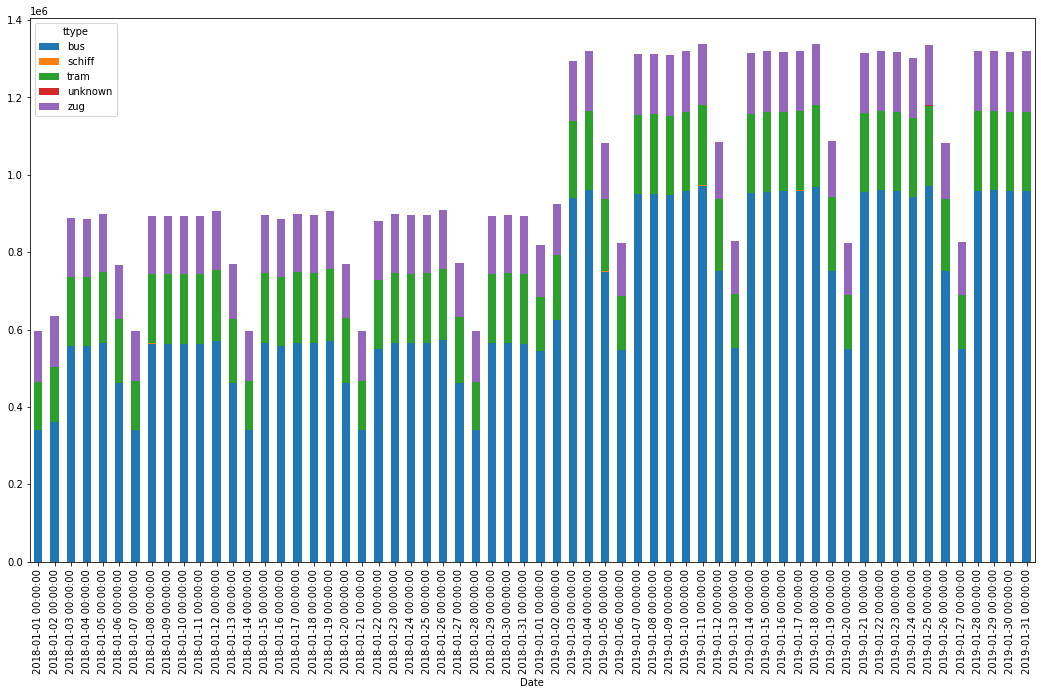

In [27]:
# Fetch number of stops per transport type for each day in January 2018 and 2019
query = """
    SELECT unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy') AS day, lower(PRODUKT_ID) AS ttype, COUNT(*) AS stops
    FROM {0}.sbb_orc
    WHERE BETRIEBSTAG LIKE '%.01.2018' OR BETRIEBSTAG LIKE '%.01.2019'
    GROUP BY BETRIEBSTAG, lower(PRODUKT_ID)
    ORDER BY day, ttype DESC
""".format(username)
pd.set_option('display.max_rows', None)
total_stops = pd.read_sql(query, conn, parse_dates=['day']) #dates are parsed with parse_dates option
total_stops.replace('', 'unknown', inplace=True) #blank values are changed with unknown

# a pivot table is created for a better chart using day as index and types as columns.
# number of stops will be the values in the columns
pivot_total_stops = total_stops.pivot_table(index='day', values='stops', columns='ttype') 
 
#pivot table is plotted as a stacked bar chart
pivot_total_stops.plot(kind='bar',stacked=True,rot=1, figsize=(18,10))
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.show()

#It can be seen in the graph that SBB services got improved in 2019 compared to 2018. Especially bus stops improved really much.
#It can be seen that SBB offers less stops in weekends. Especially on Sundays.


### Question I.b - 10 Points

Get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on a typical week day (not Saturday, not Sunday, not a bank holiday). Display the train number (`LINIEN_ID`) as well as the schedule of the trains.

__Note:__ do not hesitate to create intermediary tables. You can use the advanced search of SBB's website to check your answer, the schedule of IC from Genève to Lausanne has not changed.

In [255]:
# Drop the table of one day
# 27.12.2019 has been chosen as a typical day
query = """
    drop table if exists {0}.sbb_27_12_2019
""".format(username)
cur.execute(query)


# Create the table of one day which is not weekend or special day
query = """
    create table {0}.sbb_27_12_2019
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '27_12_2019'
""".format(username)
cur.execute(query)

#Actual Query, take unix time to sort the schedule, departure is from Geneve and time is taken as expected
#Additional trips are omited since they are not offered everyday
#Second query selects the trains with type IC and sort them regarding their departure times.
query = """
    with Times as(
        select unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_unix, 
               ABFAHRTSZEIT as expected,
               ZUSATZFAHRT_TF as additional,
               LINIEN_ID as id,
               VERKEHRSMITTEL_TEXT as text
        from {0}.sbb_27_12_2019
        where HALTESTELLEN_NAME like 'Genève' 
    )
    select id, from_unixtime(expected_unix, 'HH:mm') as schedule
    from Times
    where upper(text) LIKE 'IC'
    and additional = 'false'
    and expected != "" 
    order by expected_unix
""".format(username)
df2=pd.read_sql(query, conn)
df2

,id,schedule
0,707,05:42
1,511,06:12
2,709,06:42
3,504,06:49
4,513,07:15
5,702,07:20
6,711,07:42
7,1606,07:49
8,515,08:15
9,704,08:20


### Question I.c - 10 Points

In the exercise, we discussed a little bit about two interesting status, `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`. We will continue here to see how things evolved in the past two years.

i) Please show us how the monthly distribution of `AN_PROGNOSE_STATUS` (arrival forcast status) for __IC 733__ train at the Lausanne station changes over time, i.e., how many of them are REAL, GESCHAETZT, etc. in every month. Use `pandas` to create a pivot table if necessary.

In [53]:
#count of rows grouped by month and status for the train IC733 at the Lausanne station
query = """
    select date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM') as month_year, AN_PROGNOSE_STATUS as astatus,count(*) as count 
    from {0}.sbb_orc
    where LINIEN_ID like '733'
      and lower(LINIEN_TEXT) like 'ic%' 
      and  HALTESTELLEN_NAME like 'Lausanne'
    group by date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM'), AN_PROGNOSE_STATUS
    order by month_year
""".format(username)
df = pd.read_sql(query, conn)

In [56]:
df.head()

,month_year,astatus,count
0,2018.01,GESCHAETZT,30
1,2018.01,PROGNOSE,1
2,2018.02,PROGNOSE,1
3,2018.02,GESCHAETZT,27
4,2018.03,REAL,1


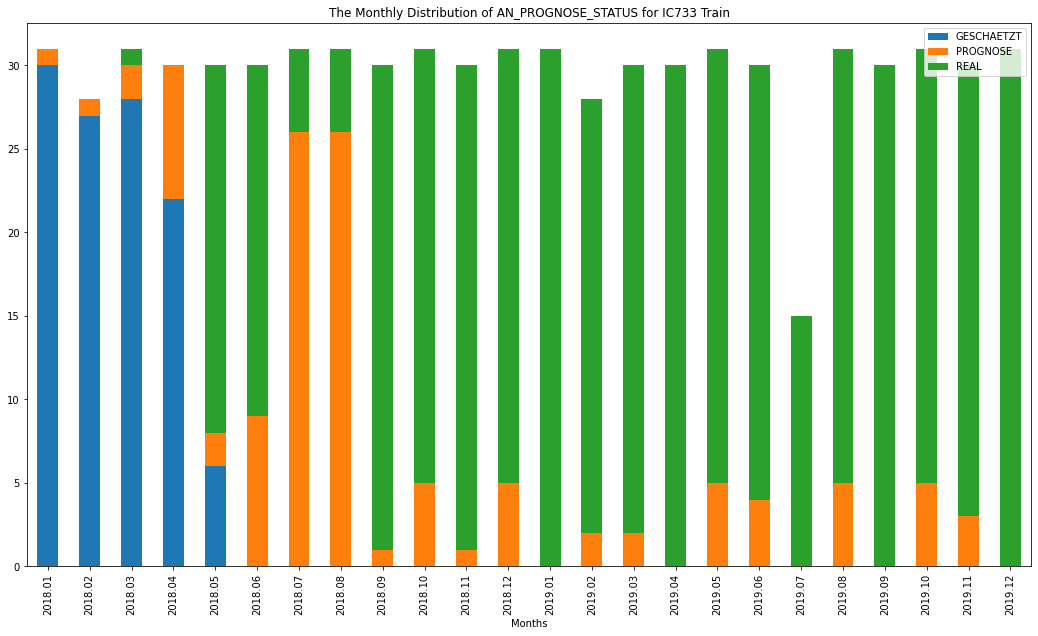

In [66]:
#we created a pivot table to avoid iteratively plotting the bars for each AN_PROGNOSE_STATUS
pivot_df = df.pivot(index='month_year', columns='astatus', values='count')
pivot_df.plot.bar(stacked=True, figsize=(18,10))
plt.xlabel('Months')
plt.title('The Monthly Distribution of AN_PROGNOSE_STATUS for IC733 Train')
plt.legend(loc='upper right')
plt.show()

ii) Show how the monthly distribution of `AN_PROGNOSE_STATUS` for all the trains that arrived at Lausanne station. Document any anything you observed.

In [63]:
#count of rows grouped by month and status for all the trains arrived at the Lausanne station
query = """
    select date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM') as month_year, AN_PROGNOSE_STATUS as astatus,count(*) as count 
    from {0}.sbb_orc
    where HALTESTELLEN_NAME like 'Lausanne'
    group by date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM'), AN_PROGNOSE_STATUS
    order by month_year
""".format(username)
df_lausanne = pd.read_sql(query, conn)

In [64]:
df_lausanne.head()

,month_year,astatus,count
0,2018.01,GESCHAETZT,13208
1,2018.01,PROGNOSE,3595
2,2018.01,UNBEKANNT,2
3,2018.02,PROGNOSE,3270
4,2018.02,UNBEKANNT,2


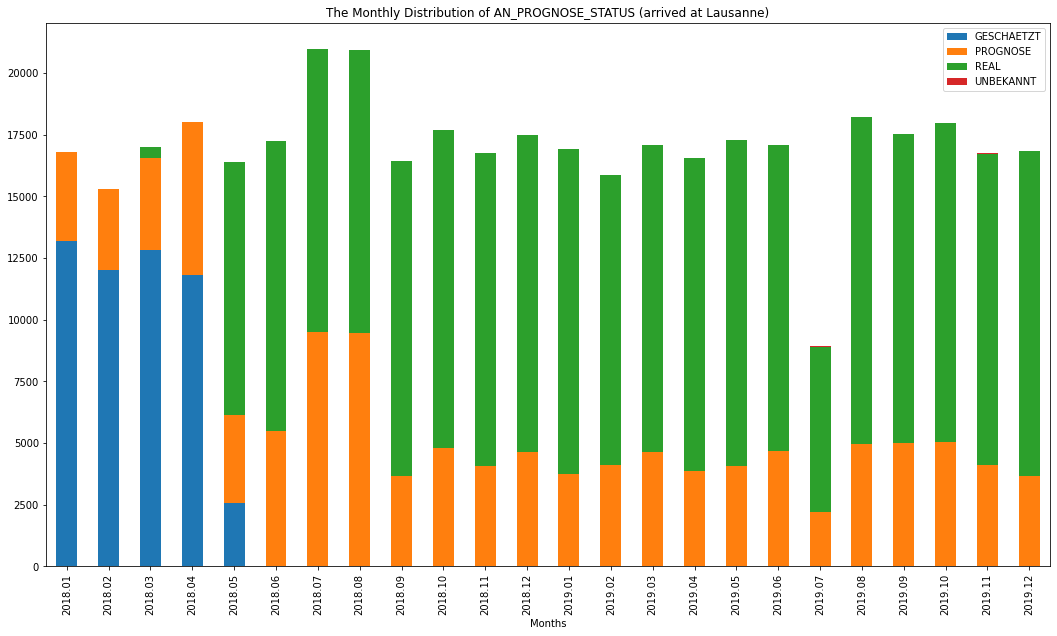

In [67]:
#we created a pivot table to avoid iteratively plotting the bars for each AN_PROGNOSE_STATUS
pivot_df = df_lausanne.pivot(index='month_year', columns='astatus', values='count')
pivot_df.plot.bar(stacked=True, figsize=(18,10))
plt.title('The Monthly Distribution of AN_PROGNOSE_STATUS (arrived at Lausanne)')
plt.legend(loc='upper right')
plt.xlabel('Months')
plt.show()

**OBSERVATION**:

In both of the graphs in the first 4 months of 2018 the number of trains with AN_PROGNOSE_STATUS Estimated(Geschätzt) are very high, which decreases in 05.2018. Starting from 06.2018, there is no Estimated(Geschätzt) status, which might refer to a change about the way SBB calculates the actual time. Probably they have decided not using the estimated time but the "REAL" arrival time as AN_PROGNOSE, since starting from 06.2018 the number of "REAL" AN_PROGNOSE_STATUS increases rapidly.

Distribution of AN_PROGNOSE_STATUS of both the trips by train IC733 and all trains arrived in Lausanne are mostly similar except a few differences. 
The number of 'REAL's in 07.2018 and 08.2018 in the first graph is significantly higher. 

In both graphs, in July 2019 the number of trips abruptly decreases. According to my research, in 07.2019 there were many cancelled trips because of the heatwave which caused deformation in the railway tracks.

### Question I.d - 20 Points

In this question, use __REAL__ for `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`.

i) Display the distribution of delays for the __IC 733__ train at the Lausanne train station. Select the information from the database as a "histogram" with bin size of one minute and plot it in a proper way.

__Note:__ when the train is ahead of schedule, count this as a delay of 0.

In [2]:
#Below query creates a table with the columns : train type (IC etc.), train id, actual arrival/departure
#time and estimated arrival/departre time
#Selected rows only with linien_id is 733, verkehrsmittel_text is IC and HALTESTELLEN_NAME is Lausanne

In [221]:
query = """
    drop table if exists {0}.sbb_time_1
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_time_1
    stored as parquet
    as 
        select upper(VERKEHRSMITTEL_TEXT) as stype, ABFAHRTSZEIT,AB_PROGNOSE,ANKUNFTSZEIT,AN_PROGNOSE,
        linien_id as id,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_departure,
               unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_arrival
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Lausanne' AND linien_id = "733" AND verkehrsmittel_text = "IC"
""".format(username)
cur.execute(query)

In [3]:
#Then delays(in minutes) are calculated above query
#when actual time > expected time, delay is (actual time - expected time)
#in order to fit these in bins of 1 min., ceil function is used (after divided by 60)
#so delas between 1 second and 60 seconds are converted to 1 min, 61-120 to 2 min etc.
#when actual time < expected time then it is 0
#when either actual time or expected time information is missing then delay is NULL
#(This logic applies both for departure and arrival time )

In [222]:
query = """
    drop table if exists {0}.sbb_delays_1
""".format(username)
cur.execute(query)
query = """
    create table {0}.sbb_delays_1
    stored as parquet
    as 
        SELECT *, 
    CASE
        WHEN actual_departure >= expected_departure THEN ceil((actual_departure - expected_departure)/60.0)
        WHEN actual_departure < expected_departure THEN 0
        ELSE NULL
    END AS delay_departure,
    CASE
        WHEN actual_arrival >= expected_arrival OR  actual_arrival < expected_arrival THEN ceil((actual_arrival - expected_arrival)/60.0)
        ELSE NULL
    END AS delay_arrival
    FROM {0}.sbb_time_1
""".format(username)
cur.execute(query)

In [4]:
#Lastly data is groped by delay (in min.) and counter number of entries for each delay interval

In [223]:
query = """
    SELECT  delay_departure, count(*) as count
    FROM {0}.sbb_delays_1
    where delay_departure is not NULL
    group by delay_departure
    order by delay_departure
    
""".format(username)
df_delay_departure = pd.read_sql(query, conn)

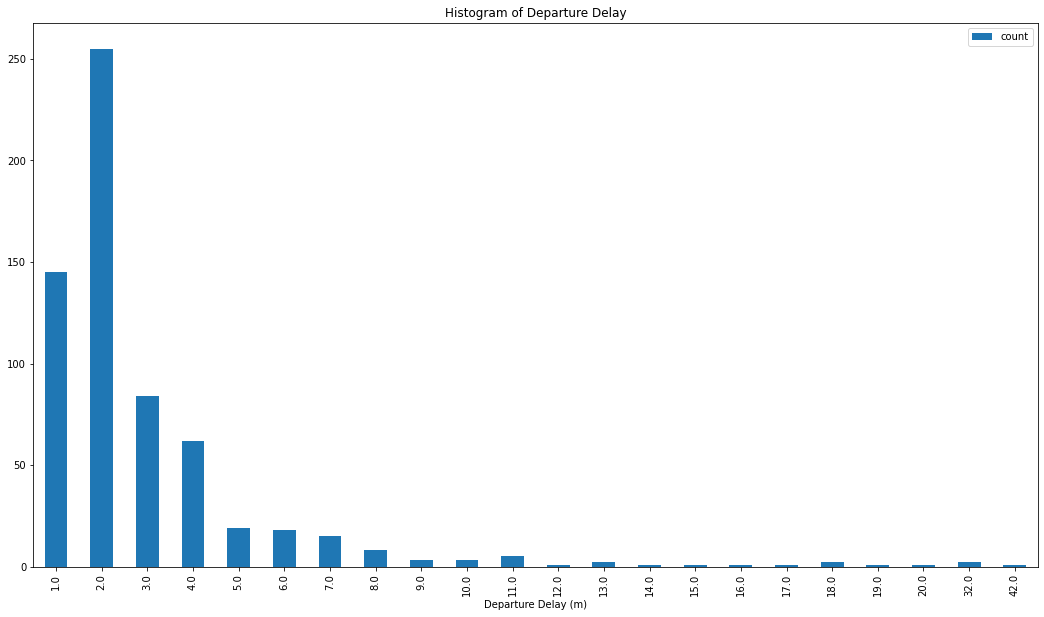

In [225]:
df_delay_departure.plot("delay_departure","count",kind='bar',figsize=(18,10))
plt.xlabel('Departure Delay (m)')
plt.title('Histogram of Departure Delay')
plt.show()

In [ ]:
#Same for arrival delays

In [226]:
query = """
    SELECT delay_arrival, count(*) as count
        FROM (SELECT   CASE
                            WHEN delay_arrival < 0 then 0
                            ELSE delay_arrival
                        END AS delay_arrival
            FROM {0}.sbb_delays_1) as d
    where delay_arrival is not NULL
    group by delay_arrival
    order by delay_arrival
    
""".format(username)
df_delay_arrival = pd.read_sql(query, conn)

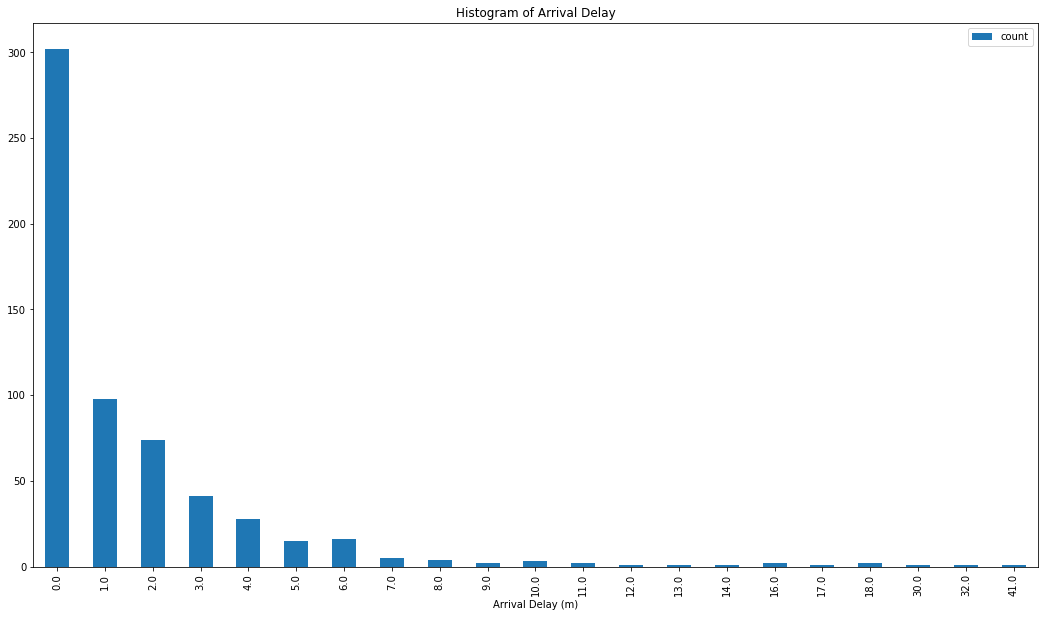

In [227]:
df_delay_arrival.plot("delay_arrival","count",kind='bar',figsize=(18,10))
plt.xlabel('Arrival Delay (m)')
plt.title('Histogram of Arrival Delay')
plt.show()

ii) Compute the 50th and 75th percentiles of delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. Which trains are the most disrupted? Can you find the tendency and interpret?

In [1]:
#Below query creates a table with the columns : train type (IC etc.), train id, actual arrival/departure
#time and estimated arrival/departre time
#Selected rows only with linien_id is between 702 and 730 verkehrsmittel_text is IC 
#and HALTESTELLEN_NAME is Geneve

In [6]:
query = """
    drop table if exists {0}.sbb_time_2
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_time_2
    stored as parquet
    as 
        select upper(VERKEHRSMITTEL_TEXT) as stype,
            upper(linien_id) as id,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_departure,
               unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_arrival
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Genève' AND CAST(linien_id AS int) BETWEEN 702 AND 730 AND CAST(linien_id AS int) % 2 = 0 AND verkehrsmittel_text = "IC"
""".format(username)
cur.execute(query)

In [7]:
#Then delays(in minutes) are calculated above query
#when actual time > expected time, delay is (actual time - expected time)
#in order to fit these in bins of 1 min., ceil function is used (after divided by 60)
#so delas between 1 second and 60 seconds are converted to 1 min, 61-120 to 2 min etc.
#when actual time < expected time then it is 0
#when either actual time or expected time information is missing then delay is NULL
#(This logic applies both for departure and arrival time )

In [8]:
query = """
    drop table if exists {0}.sbb_delays_2
""".format(username)
cur.execute(query)
query = """
    create table {0}.sbb_delays_2
    stored as parquet
    as 
        SELECT stype,id,
    CASE
        WHEN actual_departure >= expected_departure THEN actual_departure - expected_departure
        WHEN actual_departure < expected_departure THEN 0
        ELSE NULL
    END AS delay_departure,
    CASE
        WHEN actual_arrival >= expected_arrival THEN actual_arrival - expected_arrival
        WHEN actual_arrival < expected_arrival THEN 0
        ELSE NULL
    END AS delay_arrival
    FROM {0}.sbb_time_2
""".format(username)
cur.execute(query)

#### Percentiles for Departure Delay

In [9]:
#Lastly group by train ids (702,704...)
#and calculate respective percentiles(50th,75th)
#this part is for departure delay

In [10]:
query = """
    drop table if exists {0}.sbb_percentiles_lausanne_departure
""".format(username)
cur.execute(query)
query = """
CREATE TABLE {0}.sbb_percentiles_lausanne_departure
    stored as parquet
    as 
SELECT  id,
    percentile(delay_departure,0.5) as 50th_percentile,
    percentile(delay_departure,0.75) as 75th_percentile
FROM {0}.sbb_delays_2
GROUP BY id
ORDER BY id
    
""".format(username)
cur.execute(query)
query = """
SELECT id,50th_percentile,75th_percentile
FROM {0}.sbb_percentiles_lausanne_departure
    
""".format(username)
df_percentiles_departure = pd.read_sql(query, conn)
df_percentiles_departure

,id,50th_percentile,75th_percentile
0,702,64.0,96.00
1,704,103.0,190.50
2,706,95.0,179.50
3,708,107.5,220.75
4,710,73.0,149.00
5,712,80.0,135.50
6,714,74.0,139.25
7,716,68.0,125.50
8,718,63.5,116.25
9,720,73.0,118.25


#### Answer part for departure delays

Now let's look at top 4 trains with highest median(50th percentile)

In [11]:
query = """
SELECT  id, 50th_percentile, 75th_percentile
FROM {0}.sbb_percentiles_lausanne_departure
ORDER BY 50th_percentile desc
limit 4
    
""".format(username)
pd.read_sql(query, conn)


,id,50th_percentile,75th_percentile
0,708,107.5,220.75
1,704,103.0,190.50
2,706,95.0,179.50
3,728,87.0,171.00


Then top 4 trains with highest 75th percentile

In [12]:
query = """
SELECT  id, 50th_percentile, 75th_percentile
FROM {0}.sbb_percentiles_lausanne_departure
ORDER BY 75th_percentile desc
limit 4
    
""".format(username)
pd.read_sql(query, conn)



,id,50th_percentile,75th_percentile
0,708,107.5,220.75
1,704,103.0,190.50
2,706,95.0,179.50
3,728,87.0,171.00


As you can see both tables are including **708,704,706 and 728.**
Which means these are the most disrupted trains
So now let's dig into details of these trains to see if we can find any common information by collecting set of stations

In [13]:
query = """
SELECT linien_id, COLLECT_SET(haltestellen_name) as stations
FROM {0}.sbb_orc
WHERE linien_id IN ("708","704","706","728") AND verkehrsmittel_text = "IC"
GROUP BY linien_id
LIMIT 10
""".format(username)
pd.options.display.max_colwidth = 999
pd.read_sql(query, conn)

,linien_id,stations
0,706,"[""St. Gallen"",""Gossau SG"",""Flawil"",""Uzwil"",""Wil SG"",""Winterthur"",""Zürich Flughafen"",""Zürich Oerlikon"",""Zürich HB"",""Bern"",""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""Wil"",""Olten"",""Z�rich Flughafen"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport"",""Romont"",""Palézieux"",""Zürich Altstetten"",""Nyon"",""Schmitten""]"
1,704,"[""Zürich HB"",""Lenzburg"",""Aarau"",""Olten"",""Bern"",""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""Palézieux"",""Schlieren"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport"",""Nyon"",""Romont""]"
2,708,"[""St. Gallen"",""Winterthur"",""Zürich Flughafen"",""Zürich HB"",""Bern"",""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""Wil"",""Romont"",""Palézieux"",""Zürich Altstetten"",""Nyon"",""Wil SG"",""Zürich Birchsteg (Abzw)"",""Olten"",""Z�rich Flughafen"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport"",""Morges"",""Puidoux-Chexbres""]"
3,728,"[""Winterthur"",""Zürich Flughafen"",""Zürich HB"",""Bern"",""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""St. Gallen"",""Romont"",""Palézieux"",""Wil"",""Zürich Altstetten"",""Nyon"",""Zürich Oerlikon"",""Olten"",""Aarau"",""Morges"",""Aarau Ost (Abzw)"",""Z�rich Flughafen"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport"",""Winterthur West (Abzw)"",""Biel/Bienne"",""Gossau SG""]"


So all  **708,704,706 and 728.** are on a similiar path. Trains are going between Geneva and Zurich. Most importantly they are connecting 2 major airport Geneve-Aeroport and Zurich Flughafen. This could be the reason behind disruption. But this may not be the reason, so let's analyze timetables for the trains

In [20]:
query = """
SELECT linien_id,ABFAHRTSZEIT
FROM {0}.sbb_orc
WHERE linien_id = "708" AND verkehrsmittel_text = "IC"
LIMIT 8
""".format(username)
pd.options.display.max_colwidth = 999
pd.read_sql(query, conn)

,linien_id,abfahrtszeit
0,708,25.10.2019 06:25
1,708,25.10.2019 07:03
2,708,25.10.2019 07:18
3,708,25.10.2019 07:32
4,708,25.10.2019 08:34
5,708,25.10.2019 08:56
6,708,25.10.2019 09:42
7,708,25.10.2019 10:20


In [21]:
query = """
SELECT linien_id,ABFAHRTSZEIT
FROM {0}.sbb_orc
WHERE linien_id = "704" AND verkehrsmittel_text = "IC"
LIMIT 8
""".format(username)
pd.options.display.max_colwidth = 999
pd.read_sql(query, conn)

,linien_id,abfahrtszeit
0,704,25.10.2019 05:19
1,704,25.10.2019 05:40
2,704,25.10.2019 05:48
3,704,25.10.2019 06:02
4,704,25.10.2019 06:34
5,704,25.10.2019 06:56
6,704,25.10.2019 07:42
7,704,25.10.2019 08:20


In [22]:
query = """
SELECT linien_id,ABFAHRTSZEIT
FROM {0}.sbb_orc
WHERE linien_id = "706" AND verkehrsmittel_text = "IC"
LIMIT 8
""".format(username)
pd.options.display.max_colwidth = 999
pd.read_sql(query, conn)

,linien_id,abfahrtszeit
0,706,25.10.2019 05:04
1,706,25.10.2019 05:12
2,706,25.10.2019 05:18
3,706,25.10.2019 05:24
4,706,25.10.2019 05:33
5,706,25.10.2019 05:54
6,706,25.10.2019 06:09
7,706,25.10.2019 06:15


All of these trains are in the morning, so people who are going to work/school may causing delays.

#### Percentiles for Arrival Delay

In [24]:
#Lastly group by train ids (702,704...)
#and calculate respective percentiles(50th,75th)
#this part is for arrival delay

In [25]:

query = """
    drop table if exists {0}.sbb_percentiles_lausanne_arrival
""".format(username)
cur.execute(query)
query = """
CREATE TABLE {0}.sbb_percentiles_lausanne_arrival
    stored as parquet
    as 
SELECT  id,
    percentile(delay_arrival,0.5) as 50th_percentile,
    percentile(delay_arrival,0.75) as 75th_percentile
FROM {0}.sbb_delays_2
GROUP BY id
ORDER BY id
    
""".format(username)
cur.execute(query)
query = """
SELECT id,50th_percentile,75th_percentile
FROM {0}.sbb_percentiles_lausanne_arrival
    
""".format(username)
df_percentiles_arrival = pd.read_sql(query, conn)
df_percentiles_arrival

,id,50th_percentile,75th_percentile
0,702,16.5,77.50
1,704,36.0,125.50
2,706,37.0,134.50
3,708,49.0,175.00
4,710,24.0,109.50
5,712,4.5,65.00
6,714,11.0,77.00
7,716,10.5,79.25
8,718,0.0,76.00
9,720,0.0,60.00


#### Answer part for arrival delays

Now lets do the same steps from departure delays for arrival delays

In [26]:
query = """
SELECT  id, 50th_percentile, 75th_percentile
FROM {0}.sbb_percentiles_lausanne_arrival
ORDER BY 50th_percentile desc
limit 4
    
""".format(username)
pd.read_sql(query, conn)



,id,50th_percentile,75th_percentile
0,708,49.0,175.0
1,726,38.5,126.0
2,706,37.0,134.5
3,704,36.0,125.5


In [27]:
query = """
SELECT  id, 50th_percentile, 75th_percentile
FROM {0}.sbb_percentiles_lausanne_arrival
ORDER BY 50th_percentile desc
limit 4
    
""".format(username)
pd.read_sql(query, conn)




,id,50th_percentile,75th_percentile
0,708,49.0,175.0
1,726,38.5,126.0
2,706,37.0,134.5
3,704,36.0,125.5


This time **708, 726, 706, and 704** are the most disrupted ones.
So lets analyze their stations

In [28]:
query = """
SELECT linien_id, COLLECT_SET(haltestellen_name) as stations
FROM {0}.sbb_orc
WHERE linien_id IN ("708","726","706","704") AND verkehrsmittel_text = "IC"
GROUP BY linien_id
LIMIT 10
""".format(username)
pd.options.display.max_colwidth = 999
pd.read_sql(query, conn)

,linien_id,stations
0,706,"[""St. Gallen"",""Gossau SG"",""Flawil"",""Uzwil"",""Wil SG"",""Winterthur"",""Zürich Flughafen"",""Zürich Oerlikon"",""Zürich HB"",""Bern"",""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""Wil"",""Olten"",""Z�rich Flughafen"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport"",""Romont"",""Palézieux"",""Zürich Altstetten"",""Nyon"",""Schmitten""]"
1,704,"[""Zürich HB"",""Lenzburg"",""Aarau"",""Olten"",""Bern"",""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""Palézieux"",""Romont"",""Nyon"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport"",""Schlieren""]"
2,708,"[""St. Gallen"",""Winterthur"",""Zürich Flughafen"",""Zürich HB"",""Bern"",""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""Romont"",""Wil"",""Puidoux-Chexbres"",""Palézieux"",""Zürich Altstetten"",""Nyon"",""Wil SG"",""Olten"",""Z�rich Flughafen"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport"",""Morges"",""Zürich Birchsteg (Abzw)""]"
3,726,"[""Fribourg/Freiburg"",""Lausanne"",""Genève"",""Genève-Aéroport"",""St. Gallen"",""Winterthur"",""Zürich Flughafen"",""Zürich HB"",""Bern"",""Wil"",""Olten"",""Nyon"",""Romont"",""Palézieux"",""Z�rich Flughafen"",""Z�rich HB"",""Gen�ve"",""Gen�ve-A�roport""]"


Again these are connecting two main airports Geneve and Zurich

In [29]:
query = """
SELECT linien_id,ANKUNFTSZEIT
FROM {0}.sbb_orc
WHERE linien_id = "726" AND verkehrsmittel_text = "IC"
LIMIT 8
""".format(username)
pd.options.display.max_colwidth = 999
pd.read_sql(query, conn)

,linien_id,ankunftszeit
0,726,
1,726,25.10.2019 16:01
2,726,25.10.2019 16:16
3,726,25.10.2019 16:27
4,726,25.10.2019 17:28
5,726,25.10.2019 17:55
6,726,25.10.2019 18:40
7,726,25.10.2019 19:18


Only differnece is this time there is **726** instead of **728**. This time it is not in the morning but in the evening. Again delay is probably caused by people who are returning to home from work/school.

iii) Compute 25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within each hour and visualize your results. Can you find the tendency and interpret?

In [15]:
#Below query creates a table with the columns : train type (IC etc.), train id, actual arrival/departure
#time and estimated arrival/departre time, also this time hour information
#Selected rows only with HALTESTELLEN_NAME is Lausanne

In [16]:
query = """
    drop table if exists {0}.sbb_time_3
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_time_3
    stored as parquet
    as 
        select upper(VERKEHRSMITTEL_TEXT) as stype,
            upper(linien_id) as id,
            ABFAHRTSZEIT,
            substr(ABFAHRTSZEIT,12,2) as hour,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_departure,
               unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_arrival
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Lausanne'
        """.format(username)
cur.execute(query)

In [17]:
#Then delays(in minutes) are calculated above query
#when actual time > expected time, delay is (actual time - expected time)
#in order to fit these in bins of 1 min., ceil function is used (after divided by 60)
#so delas between 1 second and 60 seconds are converted to 1 min, 61-120 to 2 min etc.
#when actual time < expected time then it is 0
#when either actual time or expected time information is missing then delay is NULL
#(This logic applies both for departure and arrival time )

In [18]:
query = """
    drop table if exists {0}.sbb_delays_3
""".format(username)
cur.execute(query)
query = """
    create table {0}.sbb_delays_3
    stored as parquet
    as 
        SELECT stype,id,ABFAHRTSZEIT,hour,
    CASE
        WHEN actual_departure > expected_departure THEN actual_departure - expected_departure
        WHEN actual_departure < expected_departure THEN 0
        ELSE NULL
    END AS delay_departure,
    CASE
        WHEN actual_arrival > expected_arrival THEN actual_arrival - expected_arrival
        WHEN actual_arrival < expected_arrival THEN 0
        ELSE NULL
    END AS delay_arrival
    FROM {0}.sbb_time_3
""".format(username)
cur.execute(query)

In [19]:
#Lastly group by hours and calculate respective percentiles

In [20]:
query = """
SELECT  hour,
    percentile(delay_departure,0.25) as 25th_percentile,
    percentile(delay_departure,0.5) as 50th_percentile,
    percentile(delay_departure,0.75) as 75th_percentile
FROM {0}.sbb_delays_3
where hour != ""
GROUP BY hour
ORDER BY hour
    
""".format(username)
df_percentiles_hourly = pd.read_sql(query, conn)
df_percentiles_hourly

,hour,25th_percentile,50th_percentile,75th_percentile
0,00,48.00,79.0,189.0
1,01,55.00,93.0,210.0
2,02,38.25,59.0,111.0
3,03,30.00,44.0,75.0
4,04,37.00,48.0,71.0
5,05,38.00,53.0,77.0
6,06,44.00,63.0,106.0
7,07,49.00,75.0,143.0
8,08,51.00,82.0,162.0
9,09,48.00,70.0,134.0


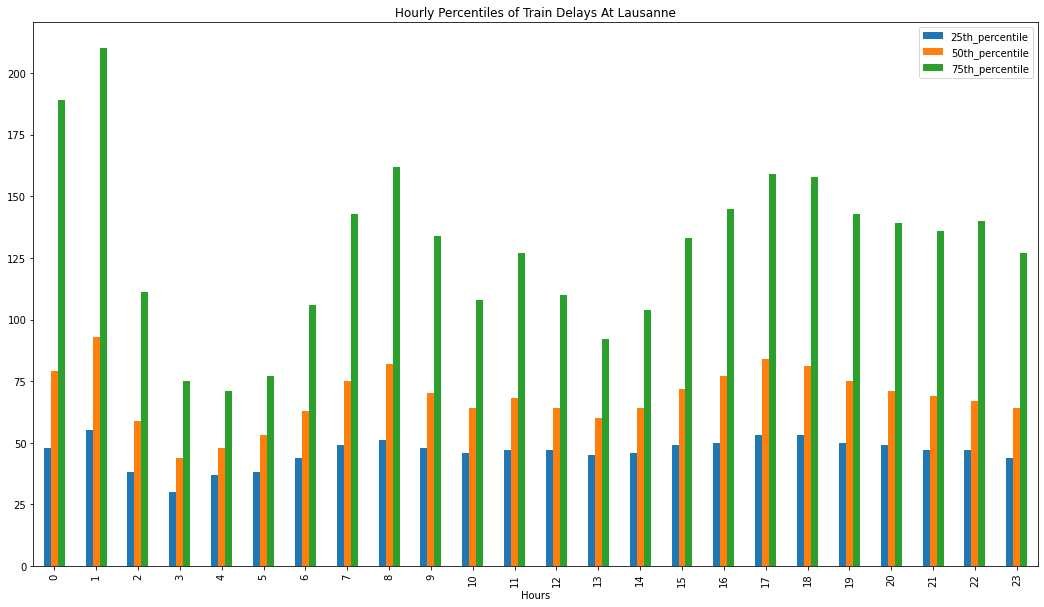

In [21]:
df_percentiles_hourly.plot.bar(figsize=(18,10))
plt.title('Hourly Percentiles of Train Delays At Lausanne')
plt.xlabel('Hours')
plt.show()

#### Answer Part

It looks like delays make a peak during rush hours when people goes to work and comes to home (at 8:00 and 18:00) . The only strange thing is also after midnight trains tend to make delay. But if we remove 00:00,01:00 and 02:00 you can see that starting from 03:00 delays starts to increase then makes a local maxia at 08:00 then delays start to decrease and after 14:00 they again starts to increase and make another local maxima at 18:00. 

iv) Did you notice something "strange"? Can you try to find the reasons behind that? Feel free to check it out from different perspectives.

**Answer:** There are two strange points in this question.
I) First one is that even though most of the trains arrive early or exactly on time, it looks like most of them are delaying on the departure. We think that the main reason behind that is there are some people getting on the train exatctly on the departure time which causes disruption. For example let's say a train's expected departure is at 15:00 but usually they depart at 15:01:01 because there are still people gettin on the train at 15:00. Which falls on 2 minutes delay on the histogram (because we are applying ceil function to seconds to convert minutes)

II)Second strange thing is related with part iii. During midnight (00:00 and 01:00) there are longer delays than usual day-time. It is possible that this is caused because there are less people working during that time interval, 

### Question I.f - 15 Points

If the departure time of one train is delayed, can it catch up with the schedule at a later station? Select __at least 2 trains from Genève (main station) to Lausanne gare__ as examples. Think about what kind of trains you want to select, direct or indirect (having stops in between), at rush hour or in midnight? Use HiveQL to select relevant data and show the results with a proper plot of arrival delay at Lausanne versus departure delay at Genève. Document and discuss your findings.

__Note__: you can write some helper functions to generate the query for you.

In [4]:
query = """
     SELECT HALTESTELLEN_NAME, AB_PROGNOSE, ABFAHRTSZEIT, BETRIEBSTAG, UNIX_TIMESTAMP(AB_PROGNOSE, 'dd.MM.yyyy HH:mm') as abpunix, UNIX_TIMESTAMP(ABFAHRTSZEIT, 'dd.MM.yyyy HH:mm') as abfunix 
     FROM {0}.sbb_orc
     WHERE HALTESTELLEN_NAME LIKE 'Genève' AND
        UPPER(VERKEHRSMITTEL_TEXT) LIKE 'TGV' AND
        AB_PROGNOSE != '' AND
        UNIX_TIMESTAMP(ABFAHRTSZEIT, 'dd.MM.yyyy HH:mm') < UNIX_TIMESTAMP(AB_PROGNOSE, 'dd.MM.yyyy HH:mm') AND
        ABFAHRTSZEIT != ''
        LIMIT 100
""".format(username)
df = pd.read_sql(query,conn,parse_dates=['ab_prognose','abfahrtszeit'])
#
query = """
        SELECT HALTESTELLEN_NAME, AN_PROGNOSE, ANKUNFTSZEIT, BETRIEBSTAG, UNIX_TIMESTAMP(AN_PROGNOSE, 'dd.MM.yyyy HH:mm') as anpunix, UNIX_TIMESTAMP(ANKUNFTSZEIT, 'dd.MM.yyyy HH:mm') as ankunix 
        FROM {0}.sbb_orc
        WHERE HALTESTELLEN_NAME LIKE 'Lausanne' AND
            UPPER(VERKEHRSMITTEL_TEXT) LIKE 'TGV' AND
            AN_PROGNOSE != '' AND
            UNIX_TIMESTAMP(AN_PROGNOSE, 'dd.MM.yyyy HH:mm') <= UNIX_TIMESTAMP(ANKUNFTSZEIT, 'dd.MM.yyyy HH:mm') AND
            ANKUNFTSZEIT != '' 
        LIMIT 100
""".format(username)
df2 = pd.read_sql(query,conn,parse_dates=['an_prognose','ankunftszeit' ])
df3 = pd.merge(df, df2, how='outer', on='betriebstag')
df4 = df3.dropna(axis=0, subset=['an_prognose', 'ab_prognose', 'anpunix', 'abpunix','ankunix' ,'abfunix' ])
df5 = df4.loc[abs(df3.anpunix - df3.abpunix) <= 2400 ]
df6=df5.loc[abs(df3.anpunix > df3.abpunix)]
df6

,haltestellen_name_x,ab_prognose,abfahrtszeit,betriebstag,abpunix,abfunix,haltestellen_name_y,an_prognose,ankunftszeit,anpunix,ankunix
14,Genève,2018-04-16 15:40:00,2018-04-16 15:39:00,16.04.2018,1.523893e+09,1.523893e+09,Lausanne,2018-04-16 16:14:51,2018-04-16 16:15:00,1.523895e+09,1.523895e+09
36,Genève,2018-11-10 15:40:06,2018-11-10 15:39:00,11.10.2018,1.539272e+09,1.539272e+09,Lausanne,2018-11-10 16:15:18,2018-11-10 16:15:00,1.539274e+09,1.539274e+09
73,Genève,2018-08-28 15:40:06,2018-08-28 15:39:00,28.08.2018,1.535471e+09,1.535471e+09,Lausanne,2018-08-28 16:14:03,2018-08-28 16:15:00,1.535473e+09,1.535473e+09


As means of transport we selected **TGV** trains since TGV trains have their final destination at Lausanne gare. Also, they do not in the intermediate stops so that the train has better chance to catch up with the original schedule and make to the final destination on time by moving faster.

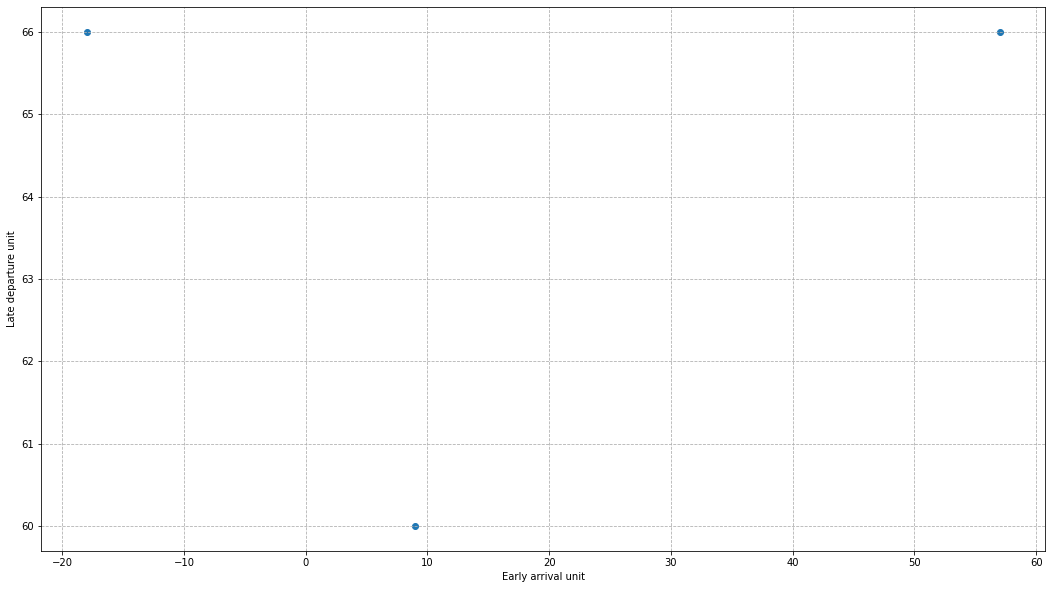

In [33]:
plt.figure(figsize=(18,10))
plt.scatter((df6['ankunftszeit'] - df6['an_prognose'])/1e9, (df6['ab_prognose'] - df6['abfahrtszeit'])/1e9)
plt.xlabel('Early arrival unit')
plt.ylabel('Late departure unit')
plt.grid(linestyle='--')
plt.show()

The first point on top left does not seem to have arrived early. I am not sure why this point is included in the plot but the remaining two points are accurate.